In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
!ls -lrt

total 41984
drwxr-xr-x 1 root root     4096 Feb 24 17:49 sample_data
-rw-r--r-- 1 root root 42975911 Feb 27 11:36 fake-and-real-news-dataset.zip
drwx------ 5 root root     4096 Feb 27 11:41 gdrive


In [4]:
os.chdir("/content/gdrive/MyDrive/ColabNotebooks/FakeNews")

In [5]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

 95% 39.0M/41.0M [00:01<00:00, 22.8MB/s]
100% 41.0M/41.0M [00:01<00:00, 30.3MB/s]


In [6]:
!unzip \*.zip  && rm *.zip

Archive:  fake-and-real-news-dataset.zip
replace Fake.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Fake.csv                
replace True.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: True.csv                


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string
import nltk

In [8]:
# load the data
trueDF = pd.read_csv("True.csv")
fakeDF = pd.read_csv("Fake.csv")

In [9]:

print("True News dataset shape: ", trueDF.shape)
print("Fake News dataset shape: ", fakeDF.shape)

True News dataset shape:  (21417, 4)
Fake News dataset shape:  (23481, 4)


In [10]:
trueDF.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [11]:
fakeDF.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [13]:
trueDF['isfake'] = 0
fakeDF['isfake'] = 1

In [27]:
df = pd.concat([trueDF, fakeDF]).reset_index()
df = df.sample(frac=1)
df.head()
print(df.shape)

(44898, 6)


In [28]:
df.head()

,index,title,text,subject,date,isfake
33300,11883,“RACIST” CONSERVATIVE Viewers Of The O’Reilly ...,"Bill O Reilly reacted to the approximate $500,...",politics,"Jan 17, 2017",1
19949,19949,Spain will not rule out exceptional measures o...,MADRID (Reuters) - Spain s central government ...,worldnews,"September 15, 2017",0
23502,2085,Stephen Hawking Says He’s Afraid Of Visiting ...,Stephen Hawking might be one of the most brill...,News,"March 20, 2017",1
41363,19946,VIDEO: BLACK MAN Tells Reporter They’re Taking...,Unidentified man helping to organize protests ...,left-news,"Sep 21, 2016",1
44087,22670,Plastic Persona: Behind the Scenes of the Ted ...,21st Century Wire says Most people accept that...,US_News,"February 4, 2016",1


In [29]:
df.duplicated().sum()

0

In [30]:
df = df.drop(['date', 'subject'], axis=1)

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)
X_train = train.drop('isfake', axis=1)
y_train = train['isfake']
X_test = test.drop('isfake', axis=1)
y_test = test['isfake']

In [33]:
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
y_train.value_counts()

1    18748
0    17170
Name: isfake, dtype: int64

In [35]:
y_test.value_counts()

1    4733
0    4247
Name: isfake, dtype: int64

In [36]:
train_news = X_train.loc[(y_train==0),:]
train_fake = X_train.loc[(y_train==1),:]

In [61]:
def LD_Measure(data1, data2, feature):
    #covert everything to lowercase
    column1 = data1[feature].str.lower() 
    #join all text columns
    text1 = ' '.join(column1)
    #drop punctuation
    exclude = set(string.punctuation)
    words1 = ''.join(char for char in text1 if char not in exclude)
    # create a list of words instead of one huge text
    words_splitted1 = words1.split()
    
    # analogously
    column2 = data2[feature].str.lower() 
    text2 = ' '.join(column2)
    words2 = ''.join(char for char in text2 if char not in exclude)
    words_splitted2 = words2.split()
    # lexical diversity measure

    ld_1 = len(set(words_splitted1)) / len(words_splitted1)
    ld_2 = len(set(words_splitted2)) / len(words_splitted2)
    return ld_1, ld_2

ld_train, ld_fake = LD_Measure(train_news, train_fake, "text")

print(f'Real News LD: {ld_train}')
print(f'Fake News LD: {ld_fake}')

Real News LD: 0.01388927542895864
Fake News LD: 0.02110787214681929


In [40]:
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)

def common_tokens_title(data, feature, name):
    column = data[feature].str.lower() 
    text = ' '.join(column)
    exclude = set(string.punctuation)
    words = ''.join(char for char in text if char not in exclude)
    words_splitted = words.split()
    words_stopped = [word for word in words_splitted if not word in stopwords]
    print(f'{name}:\n{pd.DataFrame(nltk.FreqDist(words_stopped).most_common(10))[0]}')
    
common_tokens_title(train_news, 'title', 'Most common descriptive words in Real News Titles')
print('\n')
common_tokens_title(train_fake, 'title', 'Most common descriptive words in Fake News Titles')

Most common descriptive words in Real News Titles:
0     trump
1        us
2      says
3     house
4     north
5       new
6     white
7    russia
8     korea
9    senate
Name: 0, dtype: object


Most common descriptive words in Fake News Titles:
0        video
1        trump
2        watch
3        obama
4      hillary
5      trump’s
6    president
7           us
8      clinton
9         will
Name: 0, dtype: object


In [41]:
import regex as re

# let's begin with a helper function to count punctuation
def count_punctuation(text):
    peri = re.subn(r"\.", '', text)[1]
    comm = re.subn(r"\,", '', text)[1]
    ques = re.subn(r"\?", '', text)[1]
    excl = re.subn(r"\!", '', text)[1]
    return [peri,comm, ques, excl]
    
count_punctuation('...alph!a.beta.gamma...??')

[8, 0, 2, 1]

In [42]:
def create_punctuation_df(dataset, feature):
    return dataset.apply(lambda row: pd.Series({'peri_' + feature:count_punctuation(row[feature])[0], 
                                                       'comm_' + feature:count_punctuation(row[feature])[1],
                                                      'ques_' + feature:count_punctuation(row[feature])[2],
                                                      'excl_' + feature:count_punctuation(row[feature])[3]}), axis=1)

punctuation_train_title = create_punctuation_df(train, 'title')
punctuation_test_title = create_punctuation_df(test, 'title')
punctuation_train_text = create_punctuation_df(train, 'text')
punctuation_test_text = create_punctuation_df(test, 'text')
punctuation_train_text 

,peri_text,comm_text,ques_text,excl_text
4127,24,14,0,0
40342,12,20,0,0
2710,23,27,0,0
9199,13,13,0,0
769,25,20,0,0
...,...,...,...,...
19783,2,6,0,0
34183,28,36,1,1
7029,25,21,0,0
4044,62,61,0,0


In [43]:
# count the text length per row for both features (title and text)
# and store the information in a dataframe
def create_len_df(dataset):
    return dataset.apply(lambda row: pd.Series({'length_title':len(row['title']),
                                               'length_text':len(row['text'])}), axis=1)

len_train = create_len_df(train)
len_test = create_len_df(test)

len_train

,length_title,length_text
4127,63,2723
40342,130,2019
2710,72,3151
9199,46,1998
769,63,2452
...,...,...
19783,60,518
34183,96,3682
7029,65,2594
4044,85,6611


In [44]:
def create_num_words_df(dataset):
    return dataset.apply(lambda row: pd.Series({'num_words_title':len(row['title'].split())}), axis=1)

num_words_train = create_num_words_df(train)
num_words_test = create_num_words_df(test)

num_words_train

,num_words_title
4127,10
40342,19
2710,11
9199,8
769,8
...,...
19783,10
34183,14
7029,10
4044,12


In [45]:
def create_title_ratio_df(dataset):
    return dataset.apply(lambda row: pd.Series({'title_ratio':len(row['title'])/(len(row['title']) + len(row['text']))}), axis=1)

title_ratio_train = create_title_ratio_df(train)
title_ratio_test = create_title_ratio_df(test)

title_ratio_train

,title_ratio
4127,0.022613
40342,0.060493
2710,0.022339
9199,0.022505
769,0.025050
...,...
19783,0.103806
34183,0.025410
7029,0.024445
4044,0.012694


In [96]:
X_train_punct_len = pd.concat([punctuation_train_title, 
                               punctuation_train_text, 
                               len_train, 
                               num_words_train, 
                               title_ratio_train], 
                              axis=1)

X_test_punct_len = pd.concat([punctuation_test_title, 
                              punctuation_test_text, 
                              len_test, 
                              num_words_test, 
                              title_ratio_test], 
                             axis=1)

X_train_punct_len

,peri_title,comm_title,ques_title,excl_title,peri_text,comm_text,ques_text,excl_text,length_title,length_text,num_words_title,title_ratio
4127,2,1,0,0,24,14,0,0,63,2723,10,0.022613
40342,0,0,0,0,12,20,0,0,130,2019,19,0.060493
2710,0,0,0,0,23,27,0,0,72,3151,11,0.022339
9199,0,0,0,0,13,13,0,0,46,1998,8,0.022505
769,2,0,0,0,25,20,0,0,63,2452,8,0.025050
...,...,...,...,...,...,...,...,...,...,...,...,...
19783,0,0,0,0,2,6,0,0,60,518,10,0.103806
34183,0,0,0,0,28,36,1,1,96,3682,14,0.025410
7029,2,0,0,0,25,21,0,0,65,2594,10,0.024445
4044,0,0,0,0,62,61,0,0,85,6611,12,0.012694


In [78]:
X_test_punct_len.describe()

,peri_title,comm_title,ques_title,excl_title,peri_text,comm_text,ques_text,excl_text,length_title,length_text,num_words_title,title_ratio
count,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000
mean,0.262918,0.222494,0.043318,0.083408,20.762918,20.100891,0.651893,0.393541,80.035635,2451.130512,12.438530,0.073233
std,0.686063,0.500969,0.212157,0.298589,17.523498,19.500097,1.548698,1.301315,25.121477,2084.810750,4.083289,0.140026
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,1.000000,4.000000,0.001391
25%,0.000000,0.000000,0.000000,0.000000,9.000000,8.000000,0.000000,0.000000,63.000000,1229.750000,10.000000,0.023468
50%,0.000000,0.000000,0.000000,0.000000,18.000000,17.000000,0.000000,0.000000,73.000000,2186.500000,11.000000,0.035019
75%,0.000000,0.000000,0.000000,0.000000,27.000000,26.000000,1.000000,0.000000,91.000000,3102.000000,14.000000,0.062513
max,6.000000,5.000000,3.000000,3.000000,275.000000,420.000000,27.000000,35.000000,249.000000,48835.000000,38.000000,0.995556


In [79]:
X_train_punct_len.describe()

,peri_title,comm_title,ques_title,excl_title,peri_text,comm_text,ques_text,excl_text,length_title,length_text,num_words_title,title_ratio
count,35918.000000,35918.000000,35918.000000,35918.000000,35918.000000,35918.000000,35918.000000,35918.000000,35918.000000,35918.000000,35918.000000,35918.000000
mean,0.275099,0.225430,0.041539,0.080071,20.987165,20.241049,0.685283,0.411159,80.130742,2473.604739,12.457208,0.071432
std,0.702093,0.496716,0.212510,0.301074,18.456986,20.393809,1.851222,1.491799,25.444143,2192.788117,4.118541,0.134632
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000,1.000000,0.000583
25%,0.000000,0.000000,0.000000,0.000000,10.000000,8.000000,0.000000,0.000000,63.000000,1235.000000,10.000000,0.023247
50%,0.000000,0.000000,0.000000,0.000000,18.000000,17.000000,0.000000,0.000000,73.000000,2186.000000,11.000000,0.034787
75%,0.000000,0.000000,0.000000,0.000000,27.000000,26.000000,1.000000,0.000000,91.000000,3107.000000,14.000000,0.063862
max,6.000000,5.000000,3.000000,4.000000,555.000000,518.000000,94.000000,133.000000,286.000000,51794.000000,42.000000,0.994505


In [97]:
from scipy import stats
X_train_punct_len_zscore = X_train_punct_len.apply(stats.zscore, axis=0)
mask_outliers = np.logical_not(((X_train_punct_len_zscore>5).any(axis=1)).values + ((X_train_punct_len_zscore<-5).any(axis=1)).values)
X_train_punct_len = X_train_punct_len.loc[mask_outliers,:]
y_train = y_train[X_train_punct_len.index]

In [81]:
X_train_punct_len.describe()

,peri_title,comm_title,ques_title,excl_title,peri_text,comm_text,ques_text,excl_text,length_title,length_text,num_words_title,title_ratio
count,34209.000000,34209.000000,34209.000000,34209.000000,34209.000000,34209.000000,34209.000000,34209.000000,34209.000000,34209.000000,34209.000000,34209.000000
mean,0.267152,0.215557,0.034552,0.058932,20.404513,19.501125,0.580432,0.328832,79.183782,2397.618054,12.303312,0.056816
std,0.670164,0.462537,0.182646,0.235501,14.472362,15.054339,1.269826,0.903493,24.389182,1601.138820,3.948662,0.071067
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,23.000000,1.000000,0.003235
25%,0.000000,0.000000,0.000000,0.000000,10.000000,9.000000,0.000000,0.000000,63.000000,1293.000000,10.000000,0.023246
50%,0.000000,0.000000,0.000000,0.000000,18.000000,17.000000,0.000000,0.000000,73.000000,2197.000000,11.000000,0.034422
75%,0.000000,0.000000,0.000000,0.000000,27.000000,26.000000,1.000000,0.000000,90.000000,3081.000000,14.000000,0.060803
max,3.000000,2.000000,1.000000,1.000000,113.000000,122.000000,9.000000,7.000000,206.000000,12985.000000,33.000000,0.737430


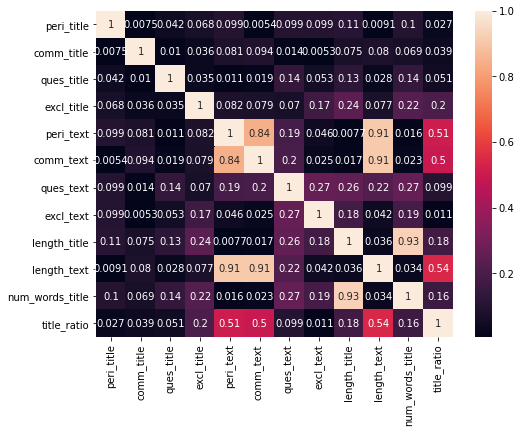

In [98]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(np.abs(X_train_punct_len.corr()), annot=True)
plt.savefig('correlation')
plt.show()

In [92]:
pd.concat([X_train_punct_len, y_train], axis=1).groupby('isfake').mean()

,peri_title,comm_title,ques_title,excl_title,peri_text,comm_text,ques_text,excl_text,length_title,length_text,num_words_title,title_ratio
isfake,,,,,,,,,,,,
0.0,0.444791,0.245674,0.006357,0.000765,20.867098,19.366215,0.093467,0.057622,64.667569,2379.861036,9.953267,0.048094
1.0,0.091875,0.185841,0.062373,0.116325,19.948081,19.634241,1.060921,0.596434,93.506940,2415.138916,14.622103,0.065423


In [99]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=21)
preds = cross_val_predict(rf, X_train_punct_len, y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
acc = accuracy_score(y_true=y_train, y_pred=preds)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.9240986159677942
acc: 0.9244935543278084


In [100]:
rf.fit(X_train_punct_len, y_train)
pd.Series(rf.feature_importances_, 
          index=X_train_punct_len.columns).sort_values(ascending=False)

length_title       0.302418
num_words_title    0.190137
ques_text          0.104818
title_ratio        0.098371
length_text        0.084169
peri_text          0.050730
excl_text          0.049423
comm_text          0.049402
peri_title         0.032196
excl_title         0.021362
comm_title         0.011283
ques_title         0.005692
dtype: float64

In [101]:
from sklearn.model_selection import GridSearchCV
params= {'n_estimators':[200,250,300],
        'criterion':['gini', 'entropy'],
        'max_depth':[5,10, None],
        'max_features':[2,4,6]}
gscv = GridSearchCV(rf, params)
gscv.fit(X_train_punct_len, y_train)
gscv.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 2,
 'n_estimators': 250}

In [73]:
rf_tuned = RandomForestClassifier(criterion='entropy', max_depth=None, max_features=2, n_estimators=200, random_state=42)
preds = cross_val_predict(rf_tuned, X_train_punct_len, y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
acc = accuracy_score(y_true=y_train, y_pred=preds)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.9185652529501109
acc: 0.91850097927446


In [102]:
rf_tuned.fit(X_train_punct_len, y_train)
pd.Series(rf_tuned.feature_importances_, 
          index=X_train_punct_len.columns).sort_values(ascending=False)

length_title       0.252627
num_words_title    0.179802
title_ratio        0.109736
ques_text          0.103369
length_text        0.097396
comm_text          0.062655
peri_text          0.061644
excl_text          0.050636
peri_title         0.037502
excl_title         0.024713
comm_title         0.012757
ques_title         0.007162
dtype: float64

In [103]:
preds_test = rf_tuned.predict(X_test_punct_len) 
f1 = f1_score(y_true=y_test, y_pred=preds_test)
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.9318521683400982
acc: 0.9289532293986636
